In [ ]:
#| default_exp visualizations

In [ ]:
#| export

a4_dims = (11.7, 8.27)
a4_width_no_margin = 10.5

In [ ]:
#| export
import seaborn as sns
import matplotlib
import matplotlib.cm
import matplotlib.colors
import matplotlib.pyplot as plt

class AlphaPeptColorMap():
    def __init__(self):

        #colorlist = ["#3FC5F0", "#42DEE1", "#7BEDC5", "#FFD479", "#16212B"]
        colorlist = ["#3FC5F0","#16212B", "#FFD479", "#42DEE1", "#7BEDC5" ]
        self.colorlist = [matplotlib.colors.to_rgba(x) for x in colorlist]
        self.colorlist_hex = colorlist
        self.colormap_linear = matplotlib.colors.LinearSegmentedColormap.from_list("alphapept",self.colorlist)
        self.colormap_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("alphapept",self.colorlist, N=5)
        self.seaborn_mapname_linear = None
        self.seaborn_mapname_linear_cut = None
    

class CmapRegistrator():
    def __init__(self):
        self._existing_matplotlib_cmaps = None
        self._define_existing_cmaps()
    
    def _define_existing_cmaps(self):
        self._existing_matplotlib_cmaps = [name for name in plt.colormaps() if not name.endswith('_r')]

    def register_colormap(self, name, colorlist):
        linmap = matplotlib.colors.LinearSegmentedColormap.from_list(name, colorlist)
        matplotlib.cm.register_cmap(name, linmap)
    

In [ ]:
#| export
import pandas as pd
import directlfq.normalization as lfq_norm
import directlfq.protein_intensity_estimation as lfq_protint
import matplotlib.pyplot as plt

class IonTraceCompararisonPlotter():
    def __init__(self, proteome_df, selected_protein, axis_unnormed, axis_normed):
        self._proteome_df = proteome_df
        self._selected_protein = selected_protein
        self._protein_df_before_norm = None
        self._protein_df_after_norm = None
        
        self.axis_unnormed = axis_unnormed
        self.axis_normed = axis_normed

        self._prepare_data_and_plot_ion_traces_before_and_after_normalization()

    def _prepare_data_and_plot_ion_traces_before_and_after_normalization(self):
        self._define_protein_dataframes()
        self._plot_before_norm()
        self._plot_after_norm()

    def _define_protein_dataframes(self):
        self._define_protein_df_before_norm()
        self._define_protein_df_after_norm()

    def _define_protein_df_before_norm(self):
        self._protein_df_before_norm = pd.DataFrame(self._proteome_df.loc[self._selected_protein])
        self._protein_df_before_norm = self._protein_df_before_norm.dropna(axis='columns', how='all')
    
    def _define_protein_df_after_norm(self):
        self._protein_df_after_norm = lfq_norm.NormalizationManagerProtein(self._protein_df_before_norm.copy(), num_samples_quadratic = 10).complete_dataframe
        self._protein_df_after_norm = self._protein_df_after_norm.dropna(axis='columns', how='all')

    def _plot_before_norm(self):
        IonTraceVisualizer(self._protein_df_before_norm,ax= self.axis_unnormed)
    
    def _plot_after_norm(self):
        visualizer = IonTraceVisualizer(self._protein_df_after_norm, ax=self.axis_normed)
        median_list = lfq_protint.get_list_with_protein_value_for_each_sample(self._protein_df_after_norm, min_nonan=1)
        visualizer.add_median_trace(median_list)


class IonTraceCompararisonPlotterNoDirectLFQTrace(IonTraceCompararisonPlotter):
    def __init__(self, proteome_df, selected_protein, ax):
        self._proteome_df = proteome_df
        self._selected_protein = selected_protein
        self._protein_df_before_norm = None
        self._protein_df_after_norm = None
        
        self.axis_normed = ax
        
        self._prepare_data_and_plot_ion_traces_before_and_after_normalization()

    
    def _prepare_data_and_plot_ion_traces_before_and_after_normalization(self):
        self._define_protein_dataframes()
        self._plot_after_norm()

    def _plot_after_norm(self):
        visualizer = IonTraceVisualizer(self._protein_df_before_norm, ax=self.axis_normed)

        

In [ ]:
#| export
import seaborn as sns
import matplotlib.cm
import numpy as np

class IonTraceVisualizer():
    def __init__(self, protein_df, ax):
        self._protein_df = protein_df
        self._plot_df = None
        self._num_samples = None
        self._ax = ax
        self._define_inputs_and_plot_ion_traces()
    
    def _define_inputs_and_plot_ion_traces(self):
        self._define_num_samples()
        self._define_prepared_dataframe()
        self._plot_ion_traces()

    def _define_num_samples(self):
        self._num_samples = len(self._protein_df.columns)

    def _plot_ion_traces(self):
        plot_values = self._plot_df.values #row contains intensity trace
        for idx in range(plot_values.shape[0]):
            x_values = np.array(range(plot_values.shape[1]))
            y_values = plot_values[idx]
            nan_mask = np.isfinite(y_values)
            self._ax.plot(x_values[nan_mask], y_values[nan_mask],color='grey', alpha=0.5)
            self._ax.scatter(x_values[nan_mask], y_values[nan_mask], color='grey', marker = 'o', s = 11)
        self._ax.set_xticks(range(self._num_samples))
        self._annotate_x_ticks(sample_names=self._protein_df.columns)

    def _define_prepared_dataframe(self):
        #drop all rows that contain less than 1 non nan value
        self._plot_df = self._protein_df.copy()
        self._plot_df = self._plot_df.dropna(axis='rows', thresh=1)
        self._plot_df.columns = range(self._num_samples)
        #self._plot_df = self._plot_df.T

    def add_median_trace(self, list_of_median_values):
        sns.lineplot(x = range(len(list_of_median_values)), y = list_of_median_values, ax=self._ax,color='black', linewidth=3)
    
    #function that annotates x ticks of an axis with the sample names
    def _annotate_x_ticks(self, sample_names):
        self._ax.set_xticklabels(sample_names, rotation=90)



In [ ]:
#| export
import seaborn as sns

class MultiOrganismMultiMethodBoxPlot():
    def __init__(self, method_ratio_results_table, ax, organisms_to_plot, fcs_to_expect):
        self._method_ratio_results_table = method_ratio_results_table
        self._color_scheme = AlphaPeptColorMap()
        self._fcs_to_expect = fcs_to_expect
        self._organisms_to_plot = organisms_to_plot
        
        self.ax = ax

        self.plot_boxplot()
        self._add_expected_fold_changes()

    def plot_boxplot(self):
        color_palette = sns.color_palette(self._color_scheme.colorlist_hex, n_colors=len(self._fcs_to_expect))
        sns.violinplot(data=self._method_ratio_results_table, x="method", y = "log2fc", hue= "organism", palette=color_palette, hue_order=self._organisms_to_plot, ax=self.ax)
    
    def _add_expected_fold_changes(self):
        if self._fcs_to_expect is not None:
            for idx, fc in enumerate(self._fcs_to_expect):
                color = self._color_scheme.colorlist[idx]
                self.ax.axhline(fc, color = color)
    
    

### Test Protein Visualization

In [ ]:
#| include: false
import matplotlib.pyplot as plt
import pandas as pd
import directlfq.utils as lfq_utils

def test_that_iontracevisualized_produces_desired_plot():
    example_prots = "../test_data/unit_tests/protein_normalization/example_proteins.tsv"
    protein_df = pd.read_csv(example_prots, sep = "\t")
    protein_df = lfq_utils.index_and_log_transform_input_df(protein_df)
    protein_df = protein_df.loc["A0A024R4E5"]

    ax = plt.subplot()
    pviz = IonTraceVisualizer(protein_df, ax)
    pviz.add_median_trace([17 for x in range(len(protein_df.columns))])

    assert len(ax.lines) == len(protein_df.index)+1


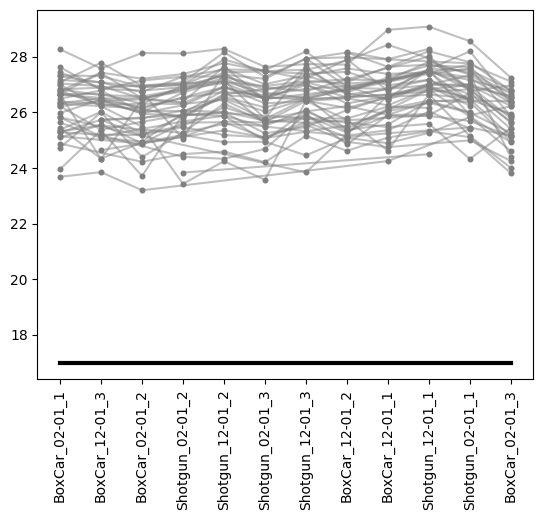

In [ ]:

test_that_iontracevisualized_produces_desired_plot()

In [ ]:
#| include: false
import matplotlib.pyplot as plt
import pandas as pd
import directlfq.utils as lfq_utils

def test_that_iontracecomparisonplotter_produces_desired_plots():
    example_prots = "../test_data/unit_tests/protein_normalization/example_proteins.tsv"
    _, axes = plt.subplots(1, 2)
    protein_df = pd.read_csv(example_prots, sep = "\t")
    protein_df = lfq_utils.index_and_log_transform_input_df(protein_df)
    complotter = IonTraceCompararisonPlotter(protein_df, selected_protein="A0A024R4E5",axis_normed=axes[0],axis_unnormed= axes[1])
    assert len(complotter.axis_unnormed.lines) == len(protein_df.loc["A0A024R4E5"].index)
    assert len(complotter.axis_normed.lines) == len(protein_df.loc["A0A024R4E5"].index)+1


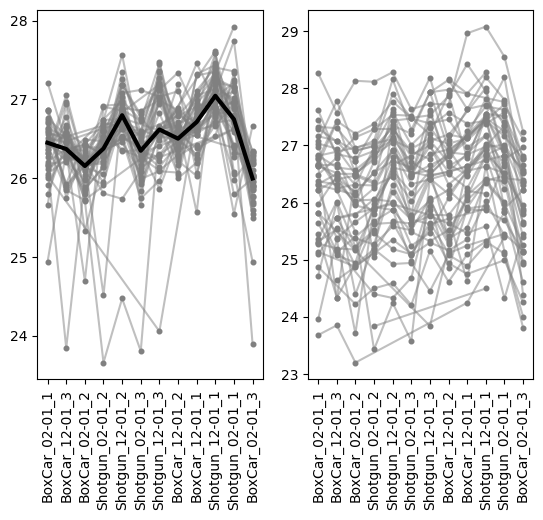

In [ ]:

test_that_iontracecomparisonplotter_produces_desired_plots()

### Learning Tests

In [ ]:
import numpy as np
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
cmap = AlphaPeptColorMap()


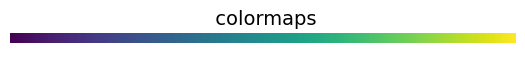

In [ ]:

plot_color_gradients("", cmap_list= [cmap.seaborn_mapname_linear])

<AxesSubplot: >

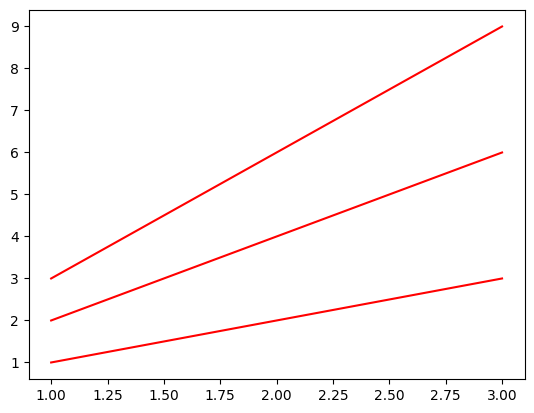

In [ ]:
import seaborn as sns
colors = ['#F00']

sns.set_palette(sns.color_palette(colors))

sns.lineplot(x = [1, 2, 3], y = [1, 2, 3])
sns.lineplot(x = [1, 2, 3], y = 2*np.array([1, 2, 3]))

sns.lineplot(x = [1, 2, 3], y = 3*np.array([1, 2, 3]))
